# Computer Vision Neural Networks from Scrratch
### Digit Classifiction

This notebook was created jointly by Roei Zaady and Omer Yanai as part of the course "Computational Learning" of Prof. Lior Rokach, The Department of Software and Information Systems Engineering, Ben-Gurion University of the Negev.

In addition, this work is based on the book "Machine Learning with PyTorch and Scikit-Learn" by Sebastian Raschka (Author), Yuxi (Hayden) Liu (Author), Vahid Mirjalili (Author), Dmytro Dzhulgakov (Foreword)
ISBN-10: 1801819319
ISBN-13: 978-1801819312

In [ ]:
import sys
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import numpy as np
from IPython.display import Image
%matplotlib inline

## Obtaining and preparing the MNIST dataset

The MNIST dataset is publicly available at http://yann.lecun.com/exdb/mnist/ and consists of the following four parts:

- Training set images: train-images-idx3-ubyte.gz (9.9 MB, 47 MB unzipped, 60,000 examples)
- Training set labels: train-labels-idx1-ubyte.gz (29 KB, 60 KB unzipped, 60,000 labels)
- Test set images: t10k-images-idx3-ubyte.gz (1.6 MB, 7.8 MB, 10,000 examples)
- Test set labels: t10k-labels-idx1-ubyte.gz (5 KB, 10 KB unzipped, 10,000 labels)



In [ ]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
X = X.values
y = y.astype(int).values

print(X.shape)
print(y.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(70000, 784)
(70000,)


Normalize to [-1, 1] range:

In [ ]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

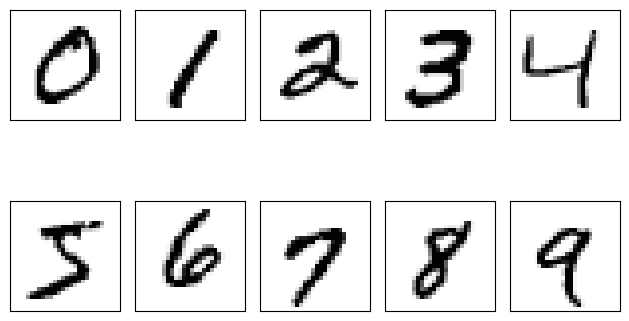

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Visualize 25 different versions of "7":

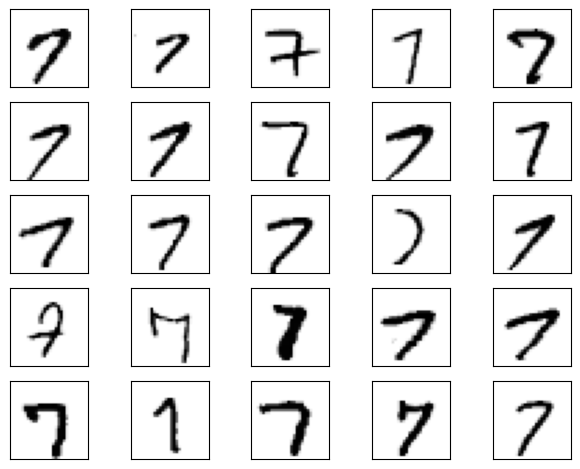

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
# plt.savefig('figures/11_5.png', dpi=300)
plt.show()

Split into training, validation, and test set:

In [ ]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=123, stratify=y_temp)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
# optional to free up some memory by deleting non-used arrays:
del X, y

(34300, 784) (34300,) (21000, 784) (21000,)


<br>
<br>

## Implementing a single hidden-layer neural network

In [ ]:
def sigmoid(z):
    return 1. / (1. + np.exp(-z))


def int_to_onehot(y, num_labels):

    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1

    return ary

class NeuralNetMLP_1h:

    def __init__(self, num_features, num_hidden, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden, num_features))
        self.bias_h = np.zeros(num_hidden)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer
        # input dim: [n_examples, n_features] dot [n_hidden, n_features].T
        # output dim: [n_examples, n_hidden]
        z_h = np.dot(x, self.weight_h.T) + self.bias_h
        a_h = sigmoid(z_h)

        # Output layer
        # input dim: [n_examples, n_hidden] dot [n_classes, n_hidden].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h, a_out

    def backward(self, x, a_h, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden]
        d_z_out__dw_out = a_h

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden]
        # output dim: [n_classes, n_hidden]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

        # [n_classes, n_hidden]
        d_z_out__a_h = self.weight_out

        # output dim: [n_examples, n_hidden]
        d_loss__a_h = np.dot(delta_out, d_z_out__a_h)

        # [n_examples, n_hidden]
        d_a_h__d_z_h = a_h * (1. - a_h) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h__d_w_h = x

        # output dim: [n_hidden, n_features]
        d_loss__d_w_h = np.dot((d_loss__a_h * d_a_h__d_z_h).T, d_z_h__d_w_h)
        d_loss__d_b_h = np.sum((d_loss__a_h * d_a_h__d_z_h), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h, d_loss__d_b_h)




model1 = NeuralNetMLP_1h(num_features=28*28,
                        num_hidden=50,
                        num_classes=10)

#### Defining functions to compute the loss and accuracy

In [ ]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas = model1.forward(X_valid)
mse = mse_loss(y_valid, probas)

predicted_labels = np.argmax(probas, axis=1)
acc = accuracy(y_valid, predicted_labels)

print(f'Initial validation MSE: {mse:.1f}')
print(f'Initial validation accuracy: {acc*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.1%


In [ ]:
num_epochs = 50
minibatch_size = 100

def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


In [ ]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

training loop

In [ ]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h, d_loss__d_b_h = model.backward(X_train_mini, a_h, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h -= learning_rate * d_loss__d_w_h
            model.bias_h -= learning_rate * d_loss__d_b_h
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc


In [ ]:
mse, acc = compute_mse_and_acc(model1, X_valid, y_valid)
print(f'Initial valid MSE: {mse:.1f}')
print(f'Initial valid accuracy: {acc*100:.1f}%')

Initial valid MSE: 0.3
Initial valid accuracy: 9.1%


In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model1, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.07 | Train Acc: 66.36% | Valid Acc: 66.87%
Epoch: 002/050 | Train MSE: 0.04 | Train Acc: 79.87% | Valid Acc: 80.06%
Epoch: 003/050 | Train MSE: 0.03 | Train Acc: 85.55% | Valid Acc: 85.10%
Epoch: 004/050 | Train MSE: 0.03 | Train Acc: 87.24% | Valid Acc: 86.88%
Epoch: 005/050 | Train MSE: 0.02 | Train Acc: 88.27% | Valid Acc: 87.95%
Epoch: 006/050 | Train MSE: 0.02 | Train Acc: 89.08% | Valid Acc: 88.73%
Epoch: 007/050 | Train MSE: 0.02 | Train Acc: 89.76% | Valid Acc: 89.37%
Epoch: 008/050 | Train MSE: 0.02 | Train Acc: 90.25% | Valid Acc: 89.90%
Epoch: 009/050 | Train MSE: 0.02 | Train Acc: 90.55% | Valid Acc: 90.18%
Epoch: 010/050 | Train MSE: 0.02 | Train Acc: 90.89% | Valid Acc: 90.61%
Epoch: 011/050 | Train MSE: 0.02 | Train Acc: 91.22% | Valid Acc: 90.76%
Epoch: 012/050 | Train MSE: 0.02 | Train Acc: 91.47% | Valid Acc: 91.02%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 91.58% | Valid Acc: 91.05%
Epoch: 014/050 | Train MSE: 0.01 | Train Acc: 91.76

### Evaluating the neural network performance

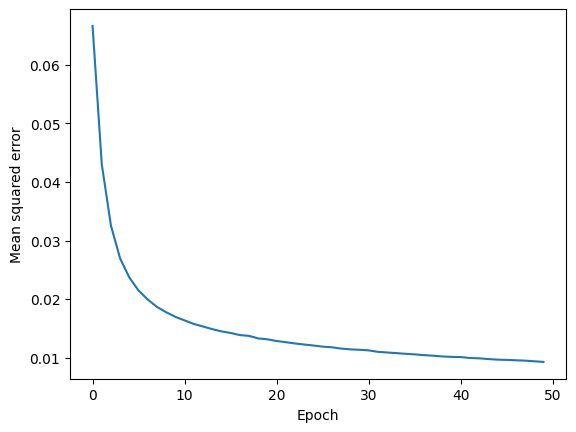

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

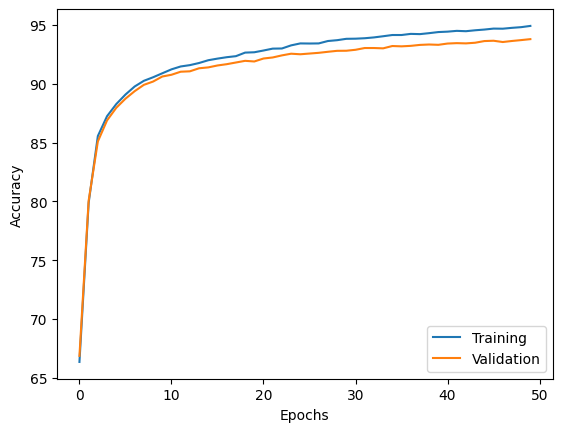

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_mse, test_acc = compute_mse_and_acc(model1, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'MSE: {test_mse:.1f}')

y_pred = model1.forward(X_test)[1]
y_pred_softmax = []
for i in y_pred:
  temp = np.exp(i)/np.sum(np.exp(i))
  y_pred_softmax.append(np.exp(i)/np.sum(np.exp(i)))

num_classes = 10
auc_scores = []

one_hot = np.zeros(num_classes)
for true_label, probs in zip(y_test, y_pred_softmax):
    one_hot[true_label] = 1
    auc = roc_auc_score(one_hot, probs)
    auc_scores.append(auc)
    one_hot[true_label] = 0

macro_auc = np.mean(auc_scores)
print("Macro AUC: %.4f" % macro_auc)

Test accuracy: 93.85%
MSE: 0.0
Macro AUC: 0.9849


## Extending the network to two hidden-layers

In [ ]:
##########################
### MODEL
##########################

class NeuralNetMLP:

    def __init__(self, num_features, num_hidden1, num_hidden2, num_classes, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        # hidden
        rng = np.random.RandomState(random_seed)

        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        self.weight_h2 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
        self.bias_h2 = np.zeros(num_hidden2)

        # output
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # Hidden layer1
        # input dim: [n_examples, n_features] dot [n_hidden1, n_features].T
        # output dim: [n_examples, n_hidden1]
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        # Hidden layer2
        # input dim: [n_examples, n_hidden1] dot [n_hidden2, n_hidden1].T
        # output dim: [n_examples, n_hidden2]
        z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
        a_h2 = sigmoid(z_h2)

        # Output layer
        # input dim: [n_examples, n_hidden2] dot [n_classes, n_hidden2].T
        # output dim: [n_examples, n_classes]
        z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
        a_out = sigmoid(z_out)
        return a_h1, a_h2, a_out

    def backward(self, x, a_h1,a_h2, a_out, y):

        #########################
        ### Output layer weights
        #########################

        # onehot encoding
        y_onehot = int_to_onehot(y, self.num_classes)

        # Part 1: dLoss/dOutWeights
        ## = dLoss/dOutAct * dOutAct/dOutNet * dOutNet/dOutWeight
        ## where DeltaOut = dLoss/dOutAct * dOutAct/dOutNet
        ## for convenient re-use

        # input/output dim: [n_examples, n_classes]
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]

        # input/output dim: [n_examples, n_classes]
        d_a_out__d_z_out = a_out * (1. - a_out) # sigmoid derivative

        # output dim: [n_examples, n_classes]
        delta_out = d_loss__d_a_out * d_a_out__d_z_out # "delta (rule) placeholder"

        # gradient for output weights

        # [n_examples, n_hidden2]
        d_z_out__dw_out = a_h2

        # input dim: [n_classes, n_examples] dot [n_examples, n_hidden2]
        # output dim: [n_classes, n_hidden2]
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__dw_out)
        d_loss__db_out = np.sum(delta_out, axis=0)


        #################################
        # Part 2: dLoss/dHiddenWeights
        ## = DeltaOut * dOutNet/dHiddenAct * dHiddenAct/dHiddenNet * dHiddenNet/dWeight

      # [n_classes, n_hidden2]
        d_z_out__a_h2 = self.weight_out

        # output dim: [n_examples, n_hidden2]
        d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)


        # [n_examples, n_hidden2]
        d_a_h2__d_z_h2 = a_h2 * (1. - a_h2) # sigmoid derivative

        # output dim: [n_examples, n_hidden2]
        delta_a_h2 = d_loss__a_h2 * d_a_h2__d_z_h2 # "delta (rule) placeholder"


        # [n_examples, n_hidden1]
        d_z_h2__d_w_h2 = a_h1

        # output dim: [n_hidden2, n_hidden1]
        d_loss__d_w_h2 = np.dot((d_loss__a_h2 * d_a_h2__d_z_h2).T, d_z_h2__d_w_h2)
        d_loss__d_b_h2 = np.sum((d_loss__a_h2 * d_a_h2__d_z_h2), axis=0)
        ##########################################

        # [n_hidden2, n_hidden1]
        d_z_h2__a_h1 = self.weight_h2

        # output dim: [n_examples, n_hidden1]
        d_loss__a_h1 = np.dot(delta_a_h2, d_z_h2__a_h1)

        # [n_examples, n_hidden1]
        d_a_h1__d_z_h1 = a_h1 * (1. - a_h1) # sigmoid derivative

        # [n_examples, n_features]
        d_z_h1__d_w_h1 = x

        # output dim: [n_hidden1, n_features]
        d_loss__d_w_h1 = np.dot((d_loss__a_h1 * d_a_h1__d_z_h1).T, d_z_h1__d_w_h1)
        d_loss__d_b_h1 = np.sum((d_loss__a_h1 * d_a_h1__d_z_h1), axis=0)

        return (d_loss__dw_out, d_loss__db_out,
                d_loss__d_w_h2, d_loss__d_b_h2,d_loss__d_w_h1, d_loss__d_b_h1)

In [ ]:
#adjusting the loss function
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        _, _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/i
    acc = correct_pred/num_examples
    return mse, acc

In [ ]:
model2 = NeuralNetMLP(num_features=28*28,
                     num_hidden1=50, num_hidden2=50,
                     num_classes=10)

In [ ]:
#train for a 2 hidden-layers model
def train(model, X_train, y_train, X_valid, y_valid, num_epochs,
          learning_rate=0.1):

    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []

    for e in range(num_epochs):

        # iterate over minibatches
        minibatch_gen = minibatch_generator(
            X_train, y_train, minibatch_size)

        for X_train_mini, y_train_mini in minibatch_gen:

            #### Compute outputs ####
            a_h1, a_h2, a_out = model.forward(X_train_mini)

            #### Compute gradients ####
            d_loss__d_w_out, d_loss__d_b_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = \
                model.backward(X_train_mini, a_h1 ,a_h2, a_out, y_train_mini)

            #### Update weights ####
            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_h2 -= learning_rate * d_loss__d_w_h2
            model.bias_h2 -= learning_rate * d_loss__d_b_h2
            model.weight_out -= learning_rate * d_loss__d_w_out
            model.bias_out -= learning_rate * d_loss__d_b_out

        #### Epoch Logging ####
        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_acc, valid_acc = train_acc*100, valid_acc*100
        epoch_train_acc.append(train_acc)
        epoch_valid_acc.append(valid_acc)
        epoch_loss.append(train_mse)
        print(f'Epoch: {e+1:03d}/{num_epochs:03d} '
              f'| Train MSE: {train_mse:.2f} '
              f'| Train Acc: {train_acc:.2f}% '
              f'| Valid Acc: {valid_acc:.2f}%')

    return epoch_loss, epoch_train_acc, epoch_valid_acc

In [ ]:
np.random.seed(123) # for the training set shuffling

epoch_loss, epoch_train_acc, epoch_valid_acc = train(
    model2, X_train, y_train, X_valid, y_valid,
    num_epochs=50, learning_rate=0.1)

Epoch: 001/050 | Train MSE: 0.09 | Train Acc: 16.77% | Valid Acc: 16.78%
Epoch: 002/050 | Train MSE: 0.09 | Train Acc: 23.27% | Valid Acc: 23.49%
Epoch: 003/050 | Train MSE: 0.09 | Train Acc: 25.89% | Valid Acc: 25.92%
Epoch: 004/050 | Train MSE: 0.08 | Train Acc: 28.82% | Valid Acc: 28.67%
Epoch: 005/050 | Train MSE: 0.07 | Train Acc: 48.91% | Valid Acc: 48.95%
Epoch: 006/050 | Train MSE: 0.06 | Train Acc: 60.79% | Valid Acc: 60.96%
Epoch: 007/050 | Train MSE: 0.05 | Train Acc: 64.91% | Valid Acc: 65.05%
Epoch: 008/050 | Train MSE: 0.05 | Train Acc: 74.21% | Valid Acc: 74.50%
Epoch: 009/050 | Train MSE: 0.04 | Train Acc: 79.70% | Valid Acc: 79.80%
Epoch: 010/050 | Train MSE: 0.03 | Train Acc: 84.01% | Valid Acc: 84.07%
Epoch: 011/050 | Train MSE: 0.03 | Train Acc: 86.22% | Valid Acc: 85.95%
Epoch: 012/050 | Train MSE: 0.03 | Train Acc: 87.27% | Valid Acc: 86.90%
Epoch: 013/050 | Train MSE: 0.02 | Train Acc: 87.92% | Valid Acc: 87.66%
Epoch: 014/050 | Train MSE: 0.02 | Train Acc: 88.62

## Evaluating the neural network performance

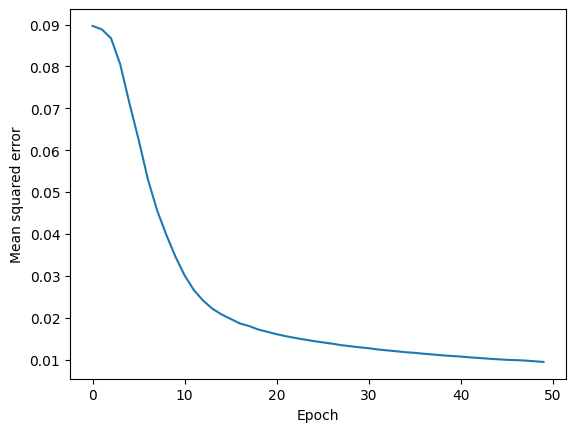

In [ ]:
plt.plot(range(len(epoch_loss)), epoch_loss)
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
plt.show()

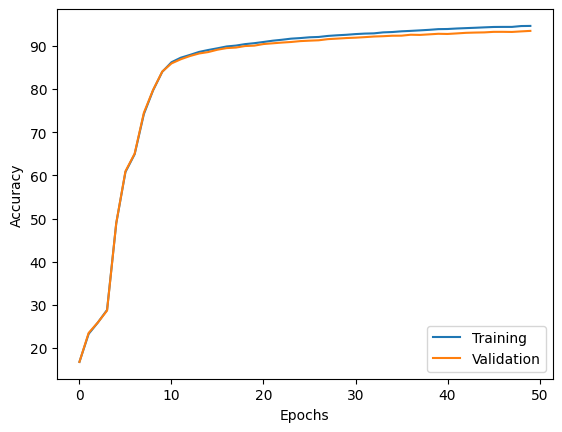

In [ ]:
plt.plot(range(len(epoch_train_acc)), epoch_train_acc,
         label='Training')
plt.plot(range(len(epoch_valid_acc)), epoch_valid_acc,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.show()

In [ ]:
test_mse, test_acc = compute_mse_and_acc(model2, X_test, y_test)
print(f'Test accuracy: {test_acc*100:.2f}%')
print(f'MSE: {test_mse:.1f}')

y_pred = model2.forward(X_test)[2]
y_pred[0].shape
y_pred_softmax = []
for i in y_pred:
  temp = np.exp(i)/np.sum(np.exp(i))
  y_pred_softmax.append(temp)

num_classes = 10
auc_scores = []
one_hot = np.zeros(num_classes)
for true_label, probs in zip(y_test, y_pred_softmax):
    one_hot[true_label] = 1
    auc = roc_auc_score(one_hot, probs)
    auc_scores.append(auc)
    one_hot[true_label] = 0

macro_auc = np.mean(auc_scores)
print("Macro AUC: %.4f" % macro_auc)

Test accuracy: 93.54%
MSE: 0.0
Macro AUC: 0.9849


Plot failure cases:

In [ ]:
X_test_subset = X_test[:1000, :]
y_test_subset = y_test[:1000]

_, _, probas = model2.forward(X_test_subset)
test_pred = np.argmax(probas, axis=1)

misclassified_images = X_test_subset[y_test_subset != test_pred][:25]
misclassified_labels = test_pred[y_test_subset != test_pred][:25]
correct_labels = y_test_subset[y_test_subset != test_pred][:25]

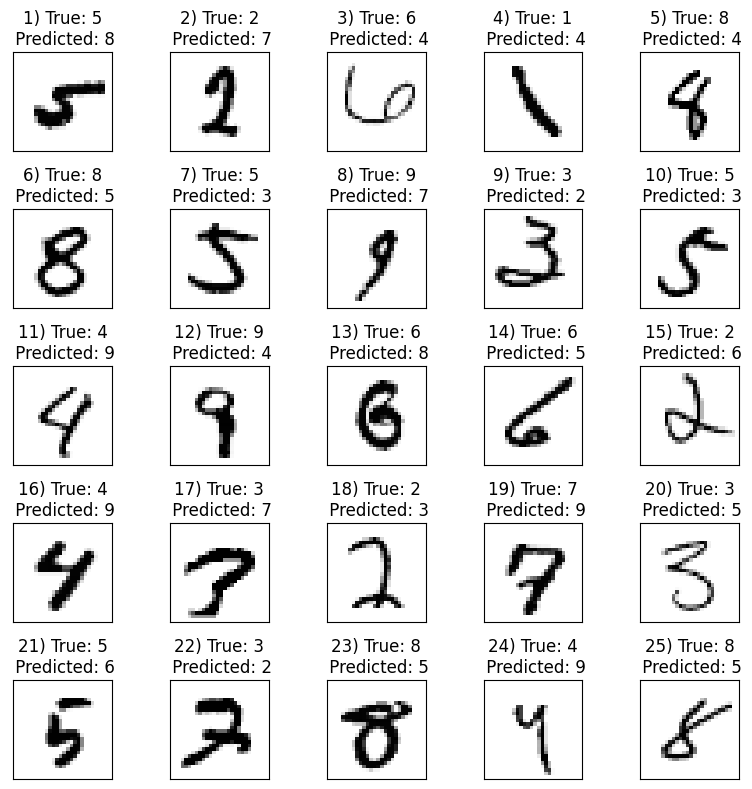

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels[i]}\n'
                    f' Predicted: {misclassified_labels[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

# KERAS implementation

In [ ]:
from keras.utils import np_utils

#Preprocessing
X_train = X_temp.reshape(X_temp.shape[0], 28, 28, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1).astype('float32')
y_train = np_utils.to_categorical(y_temp)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(49000, 28, 28, 1) (49000, 10) (21000, 28, 28, 1) (21000, 10)


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Flatten
from sklearn.metrics import roc_auc_score
from keras.optimizers import SGD
import numpy as np
np.random.RandomState(2124)

# Create the model
model3 = Sequential()
model3.add(Dense(units=500, input_shape=(28, 28), activation='sigmoid'))
model3.add(Dense(units=500, activation='sigmoid'))
model3.add(Flatten()) # must be added so the dims of the output would match the inputs
model3.add(Dense(units=10, activation='softmax'))

# Compile the model
model3.compile(loss='mse', optimizer=SGD(learning_rate=0.1), metrics=['accuracy'])

# Train the model
history = model3.fit(X_train, y_train, epochs=20, batch_size=100)

# Evaluate the model on the test data
scores = model3.evaluate(X_test, y_test)
print('\n\nTotal loss on training set: ' + str(scores[0]) +'\nAccuracy on test set ' + str(scores[1]))

y_pred = model3.predict(X_test)
auc_scores = []
for i in range(10):
    auc = roc_auc_score(y_test[:, i], y_pred[:, i])
    auc_scores.append(auc)

macro_auc = np.mean(auc_scores)
print("Macro AUC: %.4f" % macro_auc)

Epoch 1/20
490/490 [==============================] - 2s 3ms/step - loss: 0.0905 - accuracy: 0.1121
Epoch 2/20
490/490 [==============================] - 2s 3ms/step - loss: 0.0898 - accuracy: 0.1387
Epoch 3/20
490/490 [==============================] - 2s 3ms/step - loss: 0.0889 - accuracy: 0.1697
Epoch 4/20
490/490 [==============================] - 2s 3ms/step - loss: 0.0883 - accuracy: 0.1930
Epoch 5/20
490/490 [==============================] - 2s 3ms/step - loss: 0.0871 - accuracy: 0.2372
Epoch 6/20
490/490 [==============================] - 2s 3ms/step - loss: 0.0854 - accuracy: 0.2664
Epoch 7/20
490/490 [==============================] - 2s 3ms/step - loss: 0.0827 - accuracy: 0.3139
Epoch 8/20
490/490 [==============================] - 2s 3ms/step - loss: 0.0786 - accuracy: 0.3950
Epoch 9/20
490/490 [==============================] - 2s 3ms/step - loss: 0.0700 - accuracy: 0.5116
Epoch 10/20
490/490 [==============================] - 2s 4ms/step - loss: 0.0593 - accuracy: 0.6155

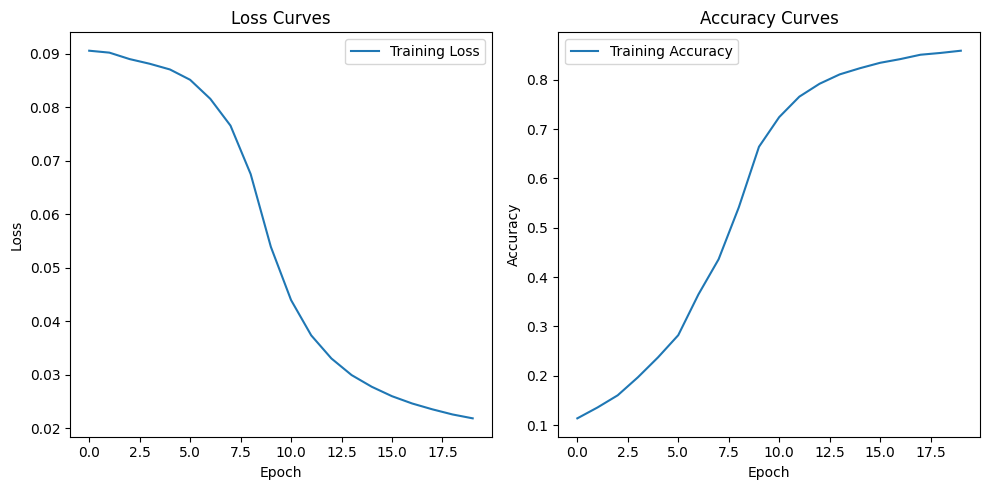

In [ ]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()